In [0]:
import sys
print(sys.version)

3.6.8 (default, Oct  7 2019, 12:59:55) 
[GCC 8.3.0]


In [0]:
!pip install twython

In [0]:
#Plot
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

#Data Packages
import math
import pandas
import numpy as np

#Progress bar
from tqdm import tqdm

#Counter
from collections import Counter

#Operation
import operator

#Natural Language Processing Packages
import re
import nltk

## Download Resources
nltk.download("vader_lexicon")
nltk.download("stopwords")
nltk.download("averaged_perceptron_tagger")
nltk.download("wordnet")

from nltk.sentiment import SentimentAnalyzer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.sentiment.util import *
from nltk import tokenize
from nltk.corpus import stopwords
from nltk.tag import PerceptronTagger
from nltk.data import find

## Machine Learning
import sklearn
import sklearn.metrics as metrics

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [0]:
hotel_df = pandas.read_csv('reviews.csv')
hotel_df.columns=['filePath','hotelName','reviewCol','ratings','groundTruth']
hotel_df.head()

,filePath,hotelName,reviewCol,ratings,groundTruth
0,data\ca\1131571\1602656\115758016.html,Kit Wat Motel Restaurant &amp; Marina,"""It was quiet and close to beach and shops. We...",4,positive
1,data\ca\1131571\1602656\115941629.html,Kit Wat Motel Restaurant &amp; Marina,"""The Family oriented setting was wonderful. We...",5,positive
2,data\ca\1131571\1602656\116213384.html,Kit Wat Motel Restaurant &amp; Marina,"""We booked the Kit-Wat motel for the long week...",5,positive
3,data\ca\1131571\1602656\116443980.html,Kit Wat Motel Restaurant &amp; Marina,"""We stayed here from August 1-3, 2011. The ro...",5,positive
4,data\ca\1131571\1602656\116486752.html,Kit Wat Motel Restaurant &amp; Marina,"""It wasn't the motels fault but the room was n...",3,negative


# Q1 Compute average Vader sentiment and average ground truth rating for each hotel.

In [0]:
reviews = hotel_df['reviewCol'].values

In [0]:
# Use vader to evaluated sentiment of reviews
def evalSentences(sentences, to_df=False, columns=[]):
    #Instantiate an instance to access SentimentIntensityAnalyzer class
    sid = SentimentIntensityAnalyzer()
    pdlist = []
    if to_df:
        for sentence in tqdm(sentences):
            ss = sid.polarity_scores(sentence)
            pdlist.append([sentence]+[ss['compound']])
        reviewDf = pandas.DataFrame(pdlist)
        reviewDf.columns = columns
        return reviewDf
    
    else:
        for sentence in tqdm(sentences):
            print(sentence)
            ss = sid.polarity_scores(sentence)
            for k in sorted(ss):
                print('{0}: {1}, '.format(k, ss[k]), end='')
            print()

In [0]:
reviewDF = evalSentences(reviews, to_df=True, columns=['reviewCol','vader'])

100%|██████████| 1743/1743 [00:02<00:00, 822.83it/s]


In [0]:
reviewDF.head()

,reviewCol,vader
0,"""It was quiet and close to beach and shops. We...",0.0000
1,"""The Family oriented setting was wonderful. We...",0.9358
2,"""We booked the Kit-Wat motel for the long week...",0.9950
3,"""We stayed here from August 1-3, 2011. The ro...",0.8849
4,"""It wasn't the motels fault but the room was n...",0.9953


In [0]:
hotel_avg = pandas.merge(hotel_df,
                 reviewDF[['reviewCol', 'vader']],
                 on='reviewCol')

In [0]:
hotel_avg = hotel_avg.groupby('hotelName').mean()
hotel_avg

,ratings,vader
hotelName,,
45th Parallel Bed and Breakfast,5.000000,0.981300
Adventure the Bruce Inn,4.000000,0.724250
Applewood Inn,4.714286,0.849329
Bear Tracks Inn,1.000000,-0.250000
Big Tub B&amp;B,4.000000,0.489050
Big Tub Harbour Resort,3.773333,0.772481
Blue Bay Motel,4.564315,0.867128
Bruce Anchor Motel and Cottage Rentals,4.093168,0.789590
Buddha Bing Tobermory,3.000000,0.968000


# Q1(b) Rank hotels

In [0]:
def dataFrameTransformation(hotelDf, reviewDF, k=500):
    reviews = reviewDF['reviewCol'].values
    
    stop = set(stopwords.words('english'))
    
    # Top-k frequent terms
    counter = Counter()
    for review in reviews:
            counter.update([word.lower() 
                            for word 
                            in re.findall(r'\w+', review) 
                            if word.lower() not in stop and len(word) > 2])
    topk = counter.most_common(k)        
    
    #Find out if a particular review has the word from topk list
    freqReview = []
    for i in range(len(reviews)):
        tempCounter = Counter([word.lower() for word in re.findall(r'\w+',reviews[i])])
        topkinReview = [1 if tempCounter[word] > 0 else 0 for (word,wordCount) in topk]
        freqReview.append(topkinReview)
        
        
    #Prepare freqReviewDf
    freqReviewDf = pandas.DataFrame(freqReview)
    dfName = []
    for c in topk:
        dfName.append(c[0])
    freqReviewDf.columns = dfName
    finalreviewDf = reviewDF.join(freqReviewDf)
    finaldf = hotelDf[['hotelName','ratings','groundTruth']].join(finalreviewDf)
    return topk, finaldf

In [0]:
topk, finaldf = dataFrameTransformation(hotel_df, reviewDF, k=500)
finaldf

,hotelName,ratings,groundTruth,reviewCol,vader,room,clean,stay,great,motel,rooms,would,place,stayed,tobermory,nice,friendly,one,comfortable,night,good,location,breakfast,well,area,staff,back,time,also,hotel,bed,nthe,little,walk,two,view,small,recommend,really,day,...,provide,pay,nit,flower,yet,surprised,cottages,arrival,chi,maureen,lunch,per,star,visited,help,truly,doors,lakeview,pit,beyond,friend,kelly,group,served,conditioner,priced,easily,washroom,meal,tips,later,continental,princess,u002fc,dated,makes,rest,nthere,children,equipped
0,Kit Wat Motel Restaurant &amp; Marina,4,positive,"""It was quiet and close to beach and shops. We...",0.0000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Kit Wat Motel Restaurant &amp; Marina,5,positive,"""The Family oriented setting was wonderful. We...",0.9358,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Kit Wat Motel Restaurant &amp; Marina,5,positive,"""We booked the Kit-Wat motel for the long week...",0.9950,1,1,0,0,1,1,1,1,0,0,1,0,0,0,0,1,0,1,1,1,1,1,1,1,1,0,1,0,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Kit Wat Motel Restaurant &amp; Marina,5,positive,"""We stayed here from August 1-3, 2011. The ro...",0.8849,1,1,0,0,0,0,0,0,1,0,1,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Kit Wat Motel Restaurant &amp; Marina,3,negative,"""It wasn't the motels fault but the room was n...",0.9953,1,1,1,0,0,0,1,1,0,0,0,1,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,1,1,0,1,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1738,Wayside Motel,5,positive,"""Perfect, all boxes checked. Clean room. Comfo...",0.8957,1,1,1,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1739,Wayside Motel,5,positive,"""We spent a very restful, comfortable night at...",0.9681,1,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1740,Wayside Motel,5,positive,"""The pictures of this motel are very accurate....",0.9837,1,1,0,0,1,1,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1741,Wayside Motel,5,positive,"""We had the pleasure of staying at this lovely...",0.9977,1,1,1,0,1,0,0,0,0,0,1,1,1,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [0]:
hotelNames = hotel_df['hotelName'].unique()

In [0]:
def getHotelRank(df, measure='ratings'):
    #Rank the hotel by ground truth rating score
    hotelRating = []
    for hotel in hotelNames:
        itemDf = df.loc[df['hotelName']==hotel]
        hotelRating.append([hotel,itemDf[measure].mean()])
    hotelRatingDfGt = pandas.DataFrame(hotelRating)
    hotelRatingDfGt.columns=['hotelName','avgRatingScore']
    hotelRatingDfGt = hotelRatingDfGt.sort_values('avgRatingScore',ascending=0)
    return hotelRatingDfGt

#(i) by Average Ground Truth Sentiment

In [0]:
hotelRatingDfGt = getHotelRank(finaldf)

In [0]:
hotelRatingDfGt.head()

,hotelName,avgRatingScore
14,MellowOut B&amp;B,5.000000
15,45th Parallel Bed and Breakfast,5.000000
16,The Purple Frog Bed and Breakfast,4.940000
17,Mustard Seed Inn Bed &amp; Breakfast,4.928571
37,My Friends Inn Manitoulin,4.912621


In [0]:
hotelRatingDfGt.tail()

,hotelName,avgRatingScore
10,Wiarton Willy&#39;s Inn,2.533333
20,The Belrose Inn and Marco Polo Boutique,2.500000
24,Harbour 90 Adult Only Guest House,2.000000
13,Bear Tracks Inn,1.000000
7,Spirit Island Adventures,1.000000


# (ii) by Average Vader Compound Sentiment Score

In [0]:
hotelRatingDfVd = getHotelRank(finaldf, measure='vader')

In [0]:
hotelRatingDfVd.head()

,hotelName,avgRatingScore
36,White Sea Resort,0.983925
15,45th Parallel Bed and Breakfast,0.981300
35,Eagles Wings B&amp;B,0.973150
16,The Purple Frog Bed and Breakfast,0.971381
22,Buddha Bing Tobermory,0.968000


In [0]:
hotelRatingDfVd.tail()

,hotelName,avgRatingScore
3,Northwinds Motel,0.418180
10,Wiarton Willy&#39;s Inn,0.300427
24,Harbour 90 Adult Only Guest House,0.161833
13,Bear Tracks Inn,-0.250000
7,Spirit Island Adventures,-0.865900


In the top 5 ranking, the result list has two same hotels in both metrics. In the bottom ranking hotels, the results are much more similar with four same hotels.

#Q2 (a) Count term frequency for each non-stopword for positive and negative reviews

In [0]:
itemAnalysisDf = finaldf[['reviewCol','groundTruth']]

In [0]:
def getTopK(df, k, label_value, label_column='groundTruth', operation=operator.eq, value_column='reviewCol'):
    stop = set(stopwords.words('english'))
    #Add possible Stop Words for Hotel Reviews
    stop.add('hotel')
    stop.add('room')
    stop.add('rooms')
    stop.add('stay')
    stop.add('staff')
    counter = Counter()
    for review in df.loc[operation(df[label_column],label_value)][value_column]:
            counter.update([word.lower() 
                            for word 
                            in re.findall(r'\w+', review) 
                            if word.lower() not in stop and len(word) > 2])
    topk = counter.most_common(k)
    return topk

In [0]:
topkGroundPos = getTopK(df=itemAnalysisDf, k=50, label_value='positive')
topkGroundPos

[('clean', 944),
 ('great', 846),
 ('motel', 751),
 ('place', 541),
 ('stayed', 538),
 ('tobermory', 530),
 ('would', 520),
 ('friendly', 509),
 ('nice', 497),
 ('comfortable', 471),
 ('well', 416),
 ('breakfast', 405),
 ('location', 394),
 ('area', 389),
 ('good', 387),
 ('one', 377),
 ('time', 359),
 ('back', 355),
 ('night', 354),
 ('also', 323),
 ('walk', 298),
 ('little', 291),
 ('recommend', 291),
 ('nthe', 277),
 ('helpful', 274),
 ('bed', 274),
 ('view', 265),
 ('day', 257),
 ('everything', 257),
 ('two', 253),
 ('really', 251),
 ('bay', 247),
 ('island', 243),
 ('beautiful', 242),
 ('town', 242),
 ('definitely', 241),
 ('made', 225),
 ('next', 225),
 ('harbour', 224),
 ('like', 222),
 ('small', 222),
 ('right', 219),
 ('coffee', 216),
 ('wonderful', 213),
 ('bruce', 213),
 ('quiet', 210),
 ('water', 208),
 ('could', 208),
 ('ferry', 205),
 ('close', 202)]

In [0]:
topkGroundNeg = getTopK(df=itemAnalysisDf, k=50, label_value='negative')
topkGroundNeg

[('would', 190),
 ('one', 147),
 ('clean', 143),
 ('motel', 141),
 ('night', 138),
 ('bed', 116),
 ('place', 113),
 ('stayed', 111),
 ('good', 101),
 ('small', 97),
 ('location', 91),
 ('nice', 91),
 ('also', 90),
 ('great', 83),
 ('nthe', 83),
 ('get', 83),
 ('bathroom', 79),
 ('like', 79),
 ('could', 79),
 ('two', 78),
 ('back', 77),
 ('water', 76),
 ('door', 75),
 ('breakfast', 75),
 ('people', 73),
 ('even', 72),
 ('beds', 71),
 ('time', 71),
 ('told', 69),
 ('price', 66),
 ('tobermory', 65),
 ('shower', 64),
 ('booked', 63),
 ('area', 62),
 ('view', 61),
 ('coffee', 61),
 ('really', 61),
 ('well', 60),
 ('little', 59),
 ('nights', 59),
 ('restaurant', 55),
 ('day', 54),
 ('friendly', 52),
 ('went', 51),
 ('air', 51),
 ('got', 51),
 ('morning', 50),
 ('old', 50),
 ('food', 50),
 ('town', 50)]

The frequencies of positive adjective words in positive reviews are more than that in the negative reviews, such as wonderful, beautiful, great and helpful. Negative reviews have negative adjective words, such ad "bad", "old" and "small". Nouns are frequent in both positive and negative reviews.

#Q2 (b) Count term frequency for each noun phrase for positive and negative reviews

In [0]:
# This grammar is described in the paper by S. N. Kim,
# T. Baldwin, and M.-Y. Kan.
# Evaluating n-gram based evaluation metrics for automatic
# keyphrase extraction.
# Technical report, University of Melbourne, Melbourne 2010.
grammar = r"""
    NBAR:
        {<NN.*|JJ>*<NN.*>}  # Nouns and Adjectives, terminated with Nouns
        
    NP:
        {<NBAR>}
        {<NBAR><IN><NBAR>}  # Above, connected with in/of/etc...
"""

In [0]:
tagger = PerceptronTagger()
pos_tag = tagger.tag
chunker = nltk.RegexpParser(grammar)

In [0]:
# Noun Phrase Extraction Support Functions
from nltk.corpus import stopwords
stopwords = stopwords.words('english')
lemmatizer = nltk.WordNetLemmatizer()
stemmer = nltk.stem.porter.PorterStemmer()

# generator, generate leaves one by one
def leaves(tree):
    """Finds NP (nounphrase) leaf nodes of a chunk tree."""
    for subtree in tree.subtrees(filter = lambda t: t.label()=='NP' or t.label()=='JJ' or t.label()=='RB'):
        yield subtree.leaves()

# stemming, lematizing, lower case... 
def normalise(word):
    """Normalises words to lowercase and stems and lemmatizes it."""
    word = word.lower()
    word = stemmer.stem(word)
    word = lemmatizer.lemmatize(word)
    return word

# stop-words and length control
def acceptable_word(word):
    """Checks conditions for acceptable word: length, stopword."""
    accepted = bool(2 <= len(word) <= 40
        and word.lower() not in stopwords)
    return accepted

# generator, create item once a time
def get_terms(tree):
    for leaf in leaves(tree):
        term = [normalise(w) for w,t in leaf if acceptable_word(w) ]
        # Phrase only
        if len(term)>1:
            yield term

In [0]:
# Flatten phrase lists to get tokens for analysis
def flatten(npTokenList):
    finalList =[]
    for phrase in npTokenList:
        token = ''
        for word in phrase:
            token += word + ' '
        finalList.append(token.rstrip())
    return finalList

In [0]:
# Revise the previous dataframe transform function...
def newDataFrameTransformation(hotelDf, reviewDF, k=50):
    reviews = reviewDF['reviewCol'].values
    
    # Top-k frequent terms
    counter = Counter()
    for review in reviews:
            counter.update(flatten([word
                            for word 
                            in get_terms(chunker.parse(pos_tag(re.findall(r'\w+', review)))) 
                            ]))
    topk = counter.most_common(k)        
    
    #Find out if a particular review has the word from topk list
    freqReview = []
    for i in range(len(reviews)):
        tempCounter = Counter(flatten([word 
                                       for word 
                                       in get_terms(chunker.parse(pos_tag(re.findall(r'\w+',reviews[i]))))]))
        topkinReview = [1 if tempCounter[word] > 0 else 0 for (word,wordCount) in topk]
        freqReview.append(topkinReview)
        
        
    #Prepare freqReviewDf
    freqReviewDf = pandas.DataFrame(freqReview)
    dfName = []
    for c in topk:
        dfName.append(c[0])
    freqReviewDf.columns = dfName
    finalreviewDf = reviewDF.join(freqReviewDf)
    finaldf = hotelDf[['hotelName','ratings','groundTruth']].join(finalreviewDf)
    return topk, finaldf

In [0]:
topk_phrase, finaldf_phrase = newDataFrameTransformation(hotel_df, reviewDF)

In [0]:
def getTopKphrase(df, k, label_value, label_column='groundTruth', operation=operator.eq, value_column='reviewCol'):

    counter = Counter()
    for review in df.loc[operation(df[label_column],label_value)][value_column]:
            counter.update(flatten([word
                                    for word
                                    in get_terms(chunker.parse(pos_tag(re.findall(r'\w+', review)))) 
                            ]))
    topk = counter.most_common(k)
    return topk

In [0]:
# Print out top phrases in positive reviews
topkphGroundPos = getTopKphrase(df=finaldf_phrase, k=50, label_value='positive')
topkphGroundPos

[('blue bay motel', 75),
 ('minut walk', 61),
 ('manitoulin island', 58),
 ('purpl frog', 56),
 ('great place', 49),
 ('bruce peninsula', 43),
 ('short walk', 42),
 ('blue bay', 41),
 ('great view', 34),
 ('next time', 31),
 ('great locat', 30),
 ('friend inn', 30),
 ('next year', 29),
 ('first time', 28),
 ('night stay', 27),
 ('bruce trail', 27),
 ('great stay', 26),
 ('hot tub', 26),
 ('second floor', 24),
 ('nthe room', 24),
 ('littl tub harbour', 24),
 ('saubl beach', 23),
 ('picnic tabl', 23),
 ('coffe maker', 23),
 ('front desk', 22),
 ('fire pit', 22),
 ('bruce anchor motel', 22),
 ('next morn', 21),
 ('flowerpot island', 21),
 ('comfort bed', 20),
 ('bruce anchor', 20),
 ('lake huron', 18),
 ('king room', 18),
 ('min walk', 17),
 ('park lot', 17),
 ('doubl bed', 17),
 ('forest hous', 17),
 ('friendli staff', 16),
 ('motel room', 16),
 ('flower pot island', 16),
 ('minut drive', 16),
 ('peacock villa', 16),
 ('kit wat', 15),
 ('great time', 15),
 ('groceri store', 15),
 ('good 

In [0]:
# Print out top phrases in negative reviews
topkphGroundNeg = getTopKphrase(df=finaldf_phrase, k=50, label_value='negative')
topkphGroundNeg

[('doubl bed', 16),
 ('front desk', 16),
 ('nthe room', 15),
 ('great locat', 13),
 ('park lot', 10),
 ('air condition', 10),
 ('coffe maker', 10),
 ('hot water', 9),
 ('continent breakfast', 9),
 ('minut walk', 8),
 ('hair dryer', 8),
 ('custom servic', 8),
 ('next day', 8),
 ('saubl beach', 7),
 ('next morn', 7),
 ('cancel polici', 6),
 ('picnic tabl', 6),
 ('manitoulin island', 6),
 ('first night', 6),
 ('front door', 6),
 ('air condit', 6),
 ('blue bay motel', 6),
 ('kit wat', 5),
 ('good size', 5),
 ('differ room', 5),
 ('credit card number', 5),
 ('long weekend', 5),
 ('first time', 5),
 ('bruce anchor', 5),
 ('ice machin', 4),
 ('fire alarm', 4),
 ('good experi', 4),
 ('larg group', 4),
 ('credit card', 4),
 ('fire pit', 4),
 ('queen bed', 4),
 ('musti smell', 4),
 ('friday night', 4),
 ('nthe owner', 4),
 ('power outag', 4),
 ('flowerpot island', 4),
 ('cigarett smoke', 4),
 ('bunk bed', 4),
 ('dine room', 4),
 ('princess hotel', 4),
 ('second night', 3),
 ('big deal', 3),
 ('c

Neutral noun phrases are frequent in both positive and negative reviews, such as front desk, double bed and park lot. People always tend to mention them no matter they like or dislike them. Positive reviews tend to have more positive noun phrases, such as "friendly staff", "great view" and "comfortable beds". On the other side, negative reviews have negative noun phrases, such as "power outage".

#Q3 (a) Calculate Mutual Information for non-stopwords

In [0]:
# get Top K mutual information terms from the dataframe
def getMI(topk, df, label_column='groundTruth'):
    miScore = []
    for word in topk:
        miScore.append([word[0]]+[metrics.mutual_info_score(finaldf[label_column], finaldf[word[0]])])
    miScoredf = pandas.DataFrame(miScore).sort_values(1,ascending=0)
    miScoredf.columns = ['Word','MI Score']
    return miScoredf

In [0]:
miScoredf = getMI(topk, finaldf)
miScoredf.head(50)

,Word,MI Score
177,told,0.020693
299,paid,0.019156
81,hosts,0.016359
164,old,0.014181
471,per,0.013207
316,bad,0.012971
97,price,0.012579
103,door,0.012471
275,asked,0.012348
92,shower,0.011274


Lots of adjectives are observed. Because adjectives are always associated with consumers' attitudes with the hotel.

# Q3 (b) Calculate Mutual Information for noun phrases

In [0]:
# get Top K mutual information terms from the dataframe
def getMI(topk, df, label_column='groundTruth'):
    miScore = []
    for word in topk:
        miScore.append([word[0]]+[metrics.mutual_info_score(finaldf_phrase[label_column], finaldf_phrase[word[0]])])
    miScoredf = pandas.DataFrame(miScore).sort_values(1,ascending=0)
    miScoredf.columns = ['Word','MI Score']
    return miScoredf

In [0]:
miScoredf = getMI(topk_phrase, finaldf_phrase)
miScoredf.head(50)
#Mutual information measures how much one random variables tells us about another.

,Word,MI Score
14,doubl bed,0.005707
48,air condition,0.005016
3,purpl frog,0.004553
10,front desk,0.003628
9,nthe room,0.003248
40,hot water,0.003174
19,next year,0.002779
26,great stay,0.002675
34,continent breakfast,0.002635
18,friend inn,0.002468


Lots of noun-noun phrases are observed, such as place, electrionics and furnitures. This is because these are the common topics that consumer always talk about.

#Q4 (a) Calculate Pointwise Mutual Information for non-stopwords for positive and negative reviews

In [0]:
def pmiCal(df, x):
    pmilist=[]
    for i in ['positive','negative']:
        for j in [0,1]:
            px = sum(df['groundTruth']==i)/len(df)
            py = sum(df[x]==j)/len(df)
            pxy = len(df[(df['groundTruth']==i) & (df[x]==j)])/len(df)
            if pxy==0:#Log 0 cannot happen
                pmi = math.log((pxy+0.0001)/(px*py+1e-5))
            else:
                pmi = math.log(pxy/(px*py))
            pmilist.append([i]+[j]+[px]+[py]+[pxy]+[pmi])
    pmidf = pandas.DataFrame(pmilist)
    pmidf.columns = ['x','y','px','py','pxy','pmi']
    return pmidf

In [0]:
def pmiIndivCal(df,x,gt, label_column='groundTruth'):
    px = sum(df[label_column]==gt)/len(df)
    py = sum(df[x]==1)/len(df)
    pxy = len(df[(df[label_column]==gt) & (df[x]==1)])/len(df)
    if pxy==0:#Log 0 cannot happen
        pmi = math.log((pxy+0.0001)/(px*py+1e-5))
    else:
        pmi = math.log(pxy/(px*py))
    return pmi

In [0]:
# Compute PMI for all terms and all possible labels
def pmiForAllCal(df, label_column='groundTruth', topk=topk):
    #Try calculate all the pmi for top k and store them into one pmidf dataframe
    pmilist = []
    pmiposlist = []
    pmineglist = []
    for word in tqdm(topk):
        pmilist.append([word[0]]+[pmiCal(df,word[0])])
        pmiposlist.append([word[0]]+[pmiIndivCal(df,word[0],'positive',label_column)])
        pmineglist.append([word[0]]+[pmiIndivCal(df,word[0],'negative',label_column)])
    pmidf = pandas.DataFrame(pmilist)
    pmiposlist = pandas.DataFrame(pmiposlist)
    pmineglist = pandas.DataFrame(pmineglist)
    pmiposlist.columns = ['word','pmi']
    pmineglist.columns = ['word','pmi']
    pmidf.columns = ['word','pmi']
    return pmiposlist, pmineglist, pmidf

In [0]:
pmiposlist, pmineglist, pmidf = pmiForAllCal(finaldf)

100%|██████████| 500/500 [00:09<00:00, 52.87it/s]


In [0]:
# Top 50 words from positive reviews
pmiposlist.sort_values('pmi',ascending=0).head(50)

,word,pmi
401,randy,0.177856
455,bob,0.177856
438,helped,0.177856
489,tips,0.177856
127,marv,0.177856
330,relaxing,0.177856
296,spotless,0.177856
262,purple,0.177856
268,frog,0.177856
427,gail,0.177856


In [0]:
# Top 50 words from negative reviews
pmineglist.sort_values('pmi',ascending=0).head(50)
#PMI is a measure of association between a feature and a class 

,word,pmi
471,per,1.491615
299,paid,1.380753
494,dated,1.275392
484,conditioner,1.275392
177,told,1.267845
316,bad,1.249859
458,noisy,1.221325
404,smell,1.191859
415,wall,1.172535
275,asked,1.152990


Positive adj words have more pmi for the positive reviews because consumers tend to use positive words to describe their experience. Negative adjective words have highter pmi values for the negative reviews, such as bad"", "noisy" and "disappointed" because consumers want to emphsize their complaints.

#Q4(b) Calculate Pointwise Mutual Information for noun phrases for positive and negative reviews

In [0]:
pmiposlist, pmineglist, pmidf = pmiForAllCal(finaldf_phrase, topk = topk_phrase)

100%|██████████| 50/50 [00:00<00:00, 60.92it/s]


In [0]:
# Top 50 words from positive reviews
pmiposlist.sort_values('pmi',ascending=0).head(50)

,word,pmi
19,next year,0.177856
3,purpl frog,0.177856
45,forest hous,0.177856
18,friend inn,0.177856
43,min walk,0.177856
26,great stay,0.177856
24,hot tub,0.138636
29,littl tub harbour,0.135297
6,short walk,0.130228
30,bruce anchor,0.126563


In [0]:
# Top 50 words from negative reviews
pmineglist.sort_values('pmi',ascending=0).head(50)

,word,pmi
48,air condition,1.344385
40,hot water,1.121242
14,doubl bed,1.121242
34,continent breakfast,1.015881
10,front desk,0.911521
23,park lot,0.876119
9,nthe room,0.858877
7,great locat,0.665766
15,coffe maker,0.620466
22,next morn,0.428094


For the positive reviews, consumers always use positive adjective words in the noun phrases. For the negative reviews, consumers tend to use noun-noun phrases which are the things that do not work well.

#Q4 (c) Repeat for top 1 and bottom 1 hotel

In [0]:
from nltk.corpus import stopwords
hotel_pos = hotel_df.loc[hotel_df['hotelName'] == 'The Purple Frog Bed and Breakfast']
hotel_pos = hotel_pos.reset_index(drop=True) 
review_pos = hotel_pos['reviewCol'].values
review_pos_DF = evalSentences(review_pos, to_df=True, columns=['reviewCol','vader'])
topk_hotel, finaldf_hotel = dataFrameTransformation(hotel_pos, review_pos_DF, k=50)

pmiposlist_hotel, pmineglist_hotel, pmidf_hotel = pmiForAllCal(finaldf_hotel, topk = topk_hotel)

100%|██████████| 50/50 [00:00<00:00, 76.79it/s]


In [0]:
# Top 50 words from positive reviews
pmiposlist_hotel.sort_values('pmi',ascending=0).head(50)

,word,pmi
0,kathy,0.0
37,beautiful,0.0
27,stayed,0.0
28,guests,0.0
29,well,0.0
30,really,0.0
31,night,0.0
32,rooms,0.0
33,day,0.0
34,bed,0.0


In [0]:
pmineglist_hotel.sort_values('pmi',ascending=0).head(50)

,word,pmi
0,kathy,2.302585
37,beautiful,2.302585
27,stayed,2.302585
28,guests,2.302585
29,well,2.302585
30,really,2.302585
31,night,2.302585
32,rooms,2.302585
33,day,2.302585
34,bed,2.302585


In [0]:
hotel_neg = hotel_df.loc[hotel_df['hotelName'] == 'Harbour 90 Adult Only Guest House']
hotel_neg = hotel_neg.reset_index(drop=True) 
review_neg = hotel_neg['reviewCol'].values
review_neg_DF = evalSentences(review_neg, to_df=True, columns=['reviewCol','vader'])
topk_neg_hotel, finaldf_neg_hotel = dataFrameTransformation(hotel_neg, review_neg_DF, k=50)

pmiposlist_hotel, pmineglist_hotel, pmidf_hotel = pmiForAllCal(finaldf_neg_hotel, topk = topk_neg_hotel)

100%|██████████| 50/50 [00:00<00:00, 76.31it/s]


In [0]:
pmiposlist_hotel.sort_values('pmi',ascending=0).head(50)

,word,pmi
14,harbour,1.098612
15,room,1.098612
16,fresh,1.098612
17,ud83d,1.098612
6,would,0.405465
12,nthe,0.405465
13,staying,0.405465
1,policy,0.000000
5,fine,0.000000
34,inconvenience,-7.013206


In [0]:
pmineglist_hotel.sort_values('pmi',ascending=0).head(50)

,word,pmi
0,cancellation,0.405465
26,didnt,0.405465
28,called,0.405465
29,hotel,0.405465
30,via,0.405465
31,refused,0.405465
32,budge,0.405465
33,minuted,0.405465
34,inconvenience,0.405465
35,chose,0.405465


The dataset are too small to provide any useful hotel-specifc insights since many words have the identicial pmi values.

#Q5 (a) (a) Histograms of ground truth and Vader sentiment scores

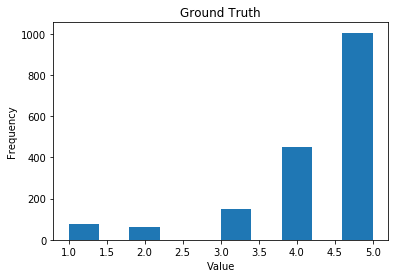

In [0]:
def getHistogram(measure, title):
    if measure=='both':
        x = [finaldf['ratings'].values/5]
        y = [finaldf['vader'].values]
        bins = np.linspace(-1, 1, 100)
        plt.title(title)
        plt.hist(x, bins, label='x')
        plt.hist(y, bins, label='y')
        plt.legend(loc='upper right')
        plt.show()
    
    else:
        plt.hist(finaldf[measure].values)
        plt.title(title)
        plt.xlabel("Value")
        plt.ylabel("Frequency")
        fig = plt.gcf()

getHistogram('ratings', 'Ground Truth')

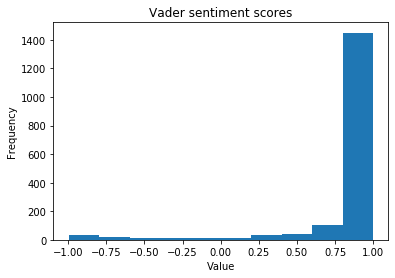

In [0]:
getHistogram('vader', 'Vader sentiment scores')

The frequency of positive review in vader score is way more than that in the groud truth scores because vader may recognize many negative reviews as positive reviews.

#Q5 (a)(b) Histogram of the number of reviews per hotel

Text(0.5, 1.0, 'The Number of Reviews per Hotel.')

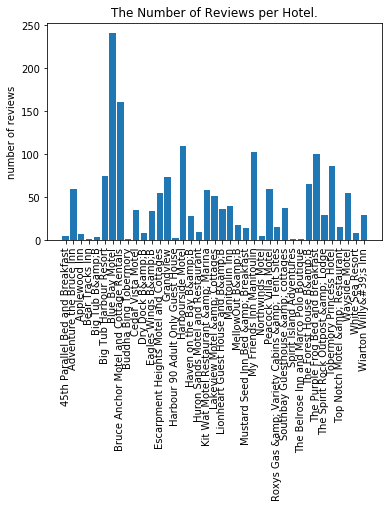

In [0]:
hotel_review = hotel_df.groupby('hotelName')
review_dict = hotel_review.groups
review = []
hotel_name = []
for hotel in review_dict:
  review.append(len(review_dict[hotel]))
  hotel_name.append(hotel)

plt.bar (hotel_name,review)
plt.xticks(rotation=90)
plt.ylabel("number of reviews")
plt.title("The Number of Reviews per Hotel.")

Some hotels get much more reviews while most hotels get moderate to low number of reviews. This is expected since it looks like a normal distribution.

#Q5 (b) (a) 5 side-by-side boxplots for ground truth star rating and Vader sentiment

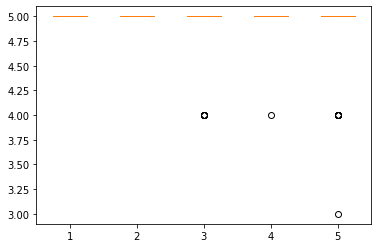

In [0]:
#Plot top 5 side-by-side boxplot for top 5 ground truth rated hotel
tp5gthotel = hotelRatingDfGt.sort_values('avgRatingScore',ascending=0).head(5)
tp5gthotel['hotelName'].values

MellowOut = finaldf.loc[finaldf['hotelName'] == tp5gthotel['hotelName'].values[0]]['ratings']
Parallel = finaldf.loc[finaldf['hotelName'] == tp5gthotel['hotelName'].values[1]]['ratings']
PurpleFrog = finaldf.loc[finaldf['hotelName'] == tp5gthotel['hotelName'].values[2]]['ratings']
MustardSeed = finaldf.loc[finaldf['hotelName'] == tp5gthotel['hotelName'].values[3]]['ratings']
MyFriends = finaldf.loc[finaldf['hotelName'] == tp5gthotel['hotelName'].values[4]]['ratings']

data = [MellowOut, Parallel, PurpleFrog, MustardSeed, MyFriends]
# multiple box plots on one figure
plt.figure()
plt.boxplot(data)
plt.show()

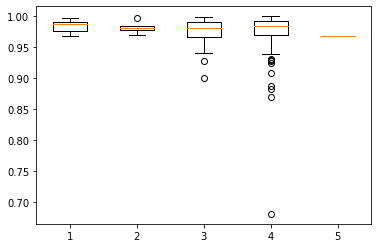

In [0]:
#Plot top 5 side-by-side boxplot for top 5 vader rated hotel
tp5vaderhotel = hotelRatingDfVd.sort_values('avgRatingScore',ascending=0).head(5)
tp5vaderhotel['hotelName'].values

WhiteSea_vader = finaldf.loc[finaldf['hotelName'] == tp5vaderhotel['hotelName'].values[0]]['vader']
Parallel_vader = finaldf.loc[finaldf['hotelName'] == tp5vaderhotel['hotelName'].values[1]]['vader']
EaglesWings_vader = finaldf.loc[finaldf['hotelName'] == tp5vaderhotel['hotelName'].values[2]]['vader']
PurpleFrog_vader = finaldf.loc[finaldf['hotelName'] == tp5vaderhotel['hotelName'].values[3]]['vader']
BuddhaBing_vader = finaldf.loc[finaldf['hotelName'] == tp5vaderhotel['hotelName'].values[4]]['vader']

data_vader = [WhiteSea_vader, Parallel_vader, EaglesWings_vader, PurpleFrog_vader, BuddhaBing_vader]
# multiple box plots on one figure
plt.figure()
plt.boxplot(data_vader)
plt.show()


#Q5 (b) (b) mean and variance of the ground truth and Vader sentiment scores for the top-5 ranked hotels

In [0]:
import pandas as pd
mean_list = []
variance_list = []
for i in data:
  mean_list.append(i.mean())
  variance_list.append(i.var())

GTmean_variance = pd.DataFrame()
GTmean_variance.insert(0, "hotelName", tp5gthotel['hotelName'].values)
GTmean_variance.insert(1, "Mean", mean_list)
GTmean_variance.insert(1, "Variance", variance_list)
GTmean_variance

,hotelName,Variance,Mean
0,MellowOut B&amp;B,0.000000,5.000000
1,45th Parallel Bed and Breakfast,0.000000,5.000000
2,The Purple Frog Bed and Breakfast,0.056970,4.940000
3,Mustard Seed Inn Bed &amp; Breakfast,0.071429,4.928571
4,My Friends Inn Manitoulin,0.100133,4.912621


In [0]:
mean_list_vader = []
variance_list_vader = []
for i in data_vader:
  mean_list_vader.append(i.mean())
  variance_list_vader.append(i.var())

Vadermean_variance = pd.DataFrame()
Vadermean_variance.insert(0, "hotelName", tp5vaderhotel['hotelName'].values)
Vadermean_variance.insert(1, "Mean", mean_list_vader)
Vadermean_variance.insert(1, "Variance", variance_list_vader)
Vadermean_variance

,hotelName,Variance,Mean
0,White Sea Resort,0.000099,0.983925
1,45th Parallel Bed and Breakfast,0.000097,0.981300
2,Eagles Wings B&amp;B,0.000480,0.973150
3,The Purple Frog Bed and Breakfast,0.001538,0.971381
4,Buddha Bing Tobermory,NaN,0.968000


#Q5 (b) (c)

Boxplots are more informative because they show 25th, 50th and 75 the Percentile, outliers, minimum and maximum values.

# Q5 (c) (a) scatterplot and heatmap of ground truth score (star rating) versus Vader sentiment score

Text(0.5, 0, 'Vader Score')

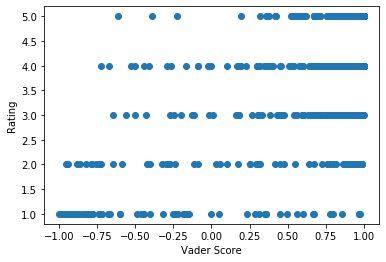

In [0]:
y = finaldf['ratings'].values
x = finaldf['vader'].values
plt.plot(x, y,"o")
plt.ylabel('Rating')
plt.xlabel('Vader Score')

In [0]:
from scipy.stats.kde import gaussian_kde

k = gaussian_kde(np.vstack([x, y]))
xi, yi = np.mgrid[x.min():x.max():x.size**0.5*1j,y.min():y.max():y.size**0.5*1j]
zi = k(np.vstack([xi.flatten(), yi.flatten()]))

Text(0, 0.5, 'Rating')

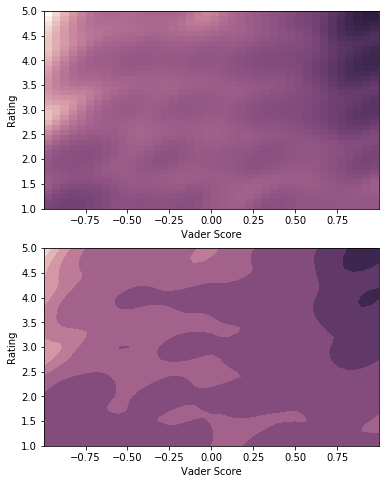

In [0]:
cmap = sns.cubehelix_palette(light=1, as_cmap=True)
fig = plt.figure(figsize=(6,8))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)

ax1.pcolormesh(xi, yi, np.log10(zi.reshape(xi.shape)), cmap=cmap)
ax2.contourf(xi, yi, np.log10(zi.reshape(xi.shape)), cmap=cmap)

ax1.set_xlim(x.min(), x.max())
ax1.set_ylim(y.min(), y.max())
ax2.set_xlim(x.min(), x.max())
ax2.set_ylim(y.min(), y.max())

ax1.set_xlabel('Vader Score')
ax1.set_ylabel('Rating')

ax2.set_xlabel('Vader Score')
ax2.set_ylabel('Rating')

The colour of heat map is darker and the density of the points on the scatterplot is larger at the upper right and bottom left. Both of the graphs show that tower vader scores tend to occur in lower ratings, while higher vader scores occur alongside higher ratings. Vader score has done a decent work in analyzing human sentiments.

#Q5 (c) (b) scatterplots of the number of reviews per hotel for average ground truth score and average Vader sentiment scor

In [0]:
length = []
for i in range(len(finaldf['reviewCol'])):
  length.append(len(finaldf['reviewCol'][i]))

Text(0.5, 0, 'Review Length')

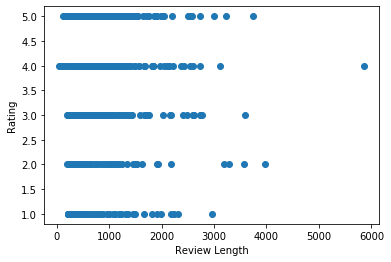

In [0]:
y = finaldf['ratings'].values
x = length
plt.plot(x, y,"o")
plt.ylabel('Rating')
plt.xlabel('Review Length')

Text(0, 0.5, 'Rating')

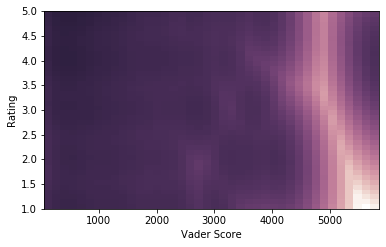

In [0]:
k = gaussian_kde(np.vstack([x, y]))
xi, yi = np.mgrid[np.array(x).min():np.array(x).max():np.array(x).size**0.5*1j,y.min():y.max():y.size**0.5*1j]
zi = k(np.vstack([xi.flatten(), yi.flatten()]))
cmap = sns.cubehelix_palette(light=1, as_cmap=True)
fig = plt.figure(figsize=(6,8))
ax1 = fig.add_subplot(211)

ax1.pcolormesh(xi, yi, np.log10(zi.reshape(xi.shape)), cmap=cmap)

ax1.set_xlim(np.array(x).min(), np.array(x).max())
ax1.set_ylim(y.min(), y.max())

ax1.set_xlabel('Vader Score')
ax1.set_ylabel('Rating')

Text(0.5, 0, 'Review Length')

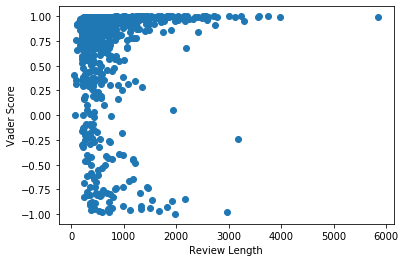

In [0]:
y = finaldf['vader'].values
x = length
plt.plot(x, y,"o")
plt.ylabel('Vader Score')
plt.xlabel('Review Length')

Text(0, 0.5, 'Rating')

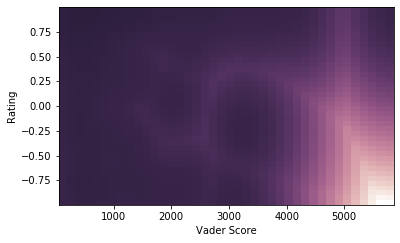

In [0]:
k = gaussian_kde(np.vstack([x, y]))
xi, yi = np.mgrid[np.array(x).min():np.array(x).max():np.array(x).size**0.5*1j,y.min():y.max():y.size**0.5*1j]
zi = k(np.vstack([xi.flatten(), yi.flatten()]))
cmap = sns.cubehelix_palette(light=1, as_cmap=True)
fig = plt.figure(figsize=(6,8))
ax1 = fig.add_subplot(211)

ax1.pcolormesh(xi, yi, np.log10(zi.reshape(xi.shape)), cmap=cmap)

ax1.set_xlim(np.array(x).min(), np.array(x).max())
ax1.set_ylim(y.min(), y.max())

ax1.set_xlabel('Vader Score')
ax1.set_ylabel('Rating')

The length of review for most positive and negative reviews are below 3000. The trends shows that the length of the reviews tend to be much longer for very high or very low vader scores. This indicates that consumers tend to say more about their experience when they are extrmely happy or angry about one hotel. When they feel it is a morderate hotel, there is not much to comment.

#Q5 (c) (c) scatterplots of the number of reviews per hotel for average ground truth score and average Vader sentiment score.

Text(0.5, 0, 'Number of Reviews')

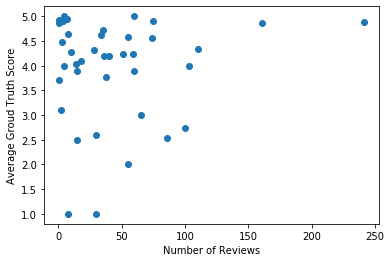

In [0]:
y = hotelRatingDfGt['avgRatingScore']
x = review
plt.plot(x, y,"o")
plt.ylabel('Average Groud Truth Score')
plt.xlabel('Number of Reviews')

Text(0.5, 0, 'Number of Reviews')

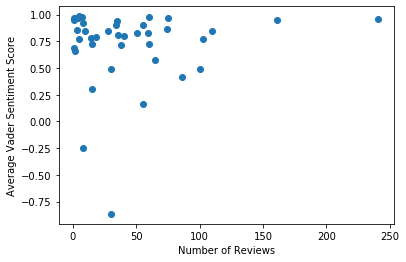

In [0]:
y = hotelRatingDfVd['avgRatingScore']
x = review
plt.plot(x, y,"o")
plt.ylabel('Average Vader Sentiment Score')
plt.xlabel('Number of Reviews')

There is an observed trend. Hotels with higher average ground truth and vader sentiment scores have more positive reviews than those with lower scores.